<a href="https://colab.research.google.com/github/George-Nyamao/Keras-cnn-mnist-tuning/blob/master/Keras_cnn_mnist_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MNIST Handwriting Using CNN and Keras**

We will use Keras on the MNIST handwriting data set, using a Convolutional Neural Network that is suited for image processing.

In [0]:
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop

Loading our raw data

In [0]:
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

Tha images are of 28x28 pixels,and therefore we need to shape them as 1x28x28 or 28x28x1, where the "1" indicates it's a single channel since the images are in grayscal. Color images would have had a "3" instead.

In [0]:
from tensorflow.keras import backend as k

if k.image_data_format() == 'channels_first':
    train_images = mnist_train_images.reshape(mnist_train_images.shape[0], 1, 28, 28)
    test_images = mnist_test_images.reshape(mnist_test_images.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    train_images = mnist_train_images.reshape(mnist_train_images.shape[0], 28, 28, 1)
    test_images = mnist_test_images.reshape(mnist_test_images.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

We then convert them to float and scale them between 0 and 1 by dividing by 255.

In [0]:
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images /= 255
test_images /= 255

We then convert our train and test labels to categorical in one-hot format.

In [0]:
train_labels = tensorflow.keras.utils.to_categorical(mnist_train_labels, 10)
test_labels = tensorflow.keras.utils.to_categorical(mnist_test_labels, 10)

Print out one sample

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


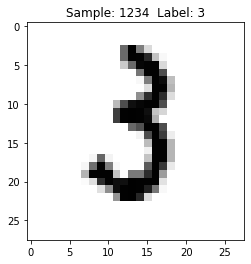

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

def display_sample(num):
    #Print the one-hot array of this sample's label 
    print(train_labels[num])  
    #Print the label converted back to a number
    label = train_labels[num].argmax(axis=0)
    #Reshape the 768 values to a 28x28 image
    image = train_images[num].reshape([28,28])
    plt.title('Sample: %d  Label: %d' % (num, label))
    plt.imshow(image, cmap=plt.get_cmap('gray_r'))
    plt.show()
    
display_sample(1234)

**Model 1**

Our first model will have two Conv2D layers, one MaxPooling2D layer, a Flatten and then two Dense layers. We will use a batch size of 32.

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
______________________________________________

In [0]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
# Train the model
history = model.fit(train_images, train_labels,
                    batch_size=32,
                    epochs=10,
                    verbose=2,
                    validation_data=(test_images, test_labels))

Epoch 1/10
1875/1875 - 7s - loss: 0.1095 - accuracy: 0.9668 - val_loss: 0.0540 - val_accuracy: 0.9823
Epoch 2/10
1875/1875 - 6s - loss: 0.0356 - accuracy: 0.9892 - val_loss: 0.0382 - val_accuracy: 0.9887
Epoch 3/10
1875/1875 - 6s - loss: 0.0200 - accuracy: 0.9937 - val_loss: 0.0364 - val_accuracy: 0.9885
Epoch 4/10
1875/1875 - 6s - loss: 0.0154 - accuracy: 0.9949 - val_loss: 0.0384 - val_accuracy: 0.9890
Epoch 5/10
1875/1875 - 6s - loss: 0.0107 - accuracy: 0.9963 - val_loss: 0.0362 - val_accuracy: 0.9908
Epoch 6/10
1875/1875 - 6s - loss: 0.0075 - accuracy: 0.9974 - val_loss: 0.0598 - val_accuracy: 0.9864
Epoch 7/10
1875/1875 - 6s - loss: 0.0064 - accuracy: 0.9977 - val_loss: 0.0472 - val_accuracy: 0.9883
Epoch 8/10
1875/1875 - 6s - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.0381 - val_accuracy: 0.9913
Epoch 9/10
1875/1875 - 6s - loss: 0.0037 - accuracy: 0.9987 - val_loss: 0.0684 - val_accuracy: 0.9870
Epoch 10/10
1875/1875 - 6s - loss: 0.0054 - accuracy: 0.9983 - val_loss: 0.0733 - 

Our model started overfitting very early when the validation accuracy exceeded the training accuracy. The validation accuracy maxed out at 99.07% after a couple of epochs, while the training set kept on increasing.

**Model 2: Dropout**

To prevent overfitting we introduce regularization. First we introduce Dropout layers in the next model and see how we do.

In [0]:
# We put the model in a function we can call easily

def MakeModel():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

model = MakeModel()

In [0]:
# Compose the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
# Train the model
history = model.fit(train_images, train_labels,
                    batch_size=32,
                    epochs=10,
                    verbose=2,
                    validation_data=(test_images, test_labels))

Epoch 1/10
1875/1875 - 7s - loss: 0.1900 - accuracy: 0.9420 - val_loss: 0.0444 - val_accuracy: 0.9855
Epoch 2/10
1875/1875 - 7s - loss: 0.0773 - accuracy: 0.9769 - val_loss: 0.0357 - val_accuracy: 0.9882
Epoch 3/10
1875/1875 - 7s - loss: 0.0582 - accuracy: 0.9823 - val_loss: 0.0330 - val_accuracy: 0.9894
Epoch 4/10
1875/1875 - 7s - loss: 0.0497 - accuracy: 0.9847 - val_loss: 0.0299 - val_accuracy: 0.9903
Epoch 5/10
1875/1875 - 7s - loss: 0.0414 - accuracy: 0.9869 - val_loss: 0.0264 - val_accuracy: 0.9906
Epoch 6/10
1875/1875 - 7s - loss: 0.0348 - accuracy: 0.9895 - val_loss: 0.0309 - val_accuracy: 0.9906
Epoch 7/10
1875/1875 - 7s - loss: 0.0297 - accuracy: 0.9902 - val_loss: 0.0284 - val_accuracy: 0.9912
Epoch 8/10
1875/1875 - 7s - loss: 0.0300 - accuracy: 0.9908 - val_loss: 0.0258 - val_accuracy: 0.9917
Epoch 9/10
1875/1875 - 7s - loss: 0.0253 - accuracy: 0.9917 - val_loss: 0.0245 - val_accuracy: 0.9929
Epoch 10/10
1875/1875 - 7s - loss: 0.0222 - accuracy: 0.9926 - val_loss: 0.0322 - 

The model has greatly improved, with both the train and validation accuracy at 99.2%. But as we can see, there is a little bit of overfitting.

We will try a different batch size of 1000.

**Model 3: Batch Size**

In [14]:
model = MakeModel()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Batch size of 1000
history = model.fit(train_images, train_labels,
                    batch_size=1000,
                    epochs=10,
                    verbose=2,
                    validation_data=(test_images, test_labels))

Epoch 1/10
60/60 - 2s - loss: 0.5381 - accuracy: 0.8383 - val_loss: 0.1324 - val_accuracy: 0.9598
Epoch 2/10
60/60 - 2s - loss: 0.1531 - accuracy: 0.9550 - val_loss: 0.0650 - val_accuracy: 0.9797
Epoch 3/10
60/60 - 2s - loss: 0.1000 - accuracy: 0.9704 - val_loss: 0.0489 - val_accuracy: 0.9849
Epoch 4/10
60/60 - 2s - loss: 0.0771 - accuracy: 0.9774 - val_loss: 0.0394 - val_accuracy: 0.9858
Epoch 5/10
60/60 - 2s - loss: 0.0650 - accuracy: 0.9809 - val_loss: 0.0360 - val_accuracy: 0.9877
Epoch 6/10
60/60 - 2s - loss: 0.0554 - accuracy: 0.9833 - val_loss: 0.0352 - val_accuracy: 0.9882
Epoch 7/10
60/60 - 2s - loss: 0.0502 - accuracy: 0.9845 - val_loss: 0.0312 - val_accuracy: 0.9892
Epoch 8/10
60/60 - 2s - loss: 0.0456 - accuracy: 0.9864 - val_loss: 0.0310 - val_accuracy: 0.9904
Epoch 9/10
60/60 - 2s - loss: 0.0405 - accuracy: 0.9870 - val_loss: 0.0290 - val_accuracy: 0.9902
Epoch 10/10
60/60 - 2s - loss: 0.0370 - accuracy: 0.9889 - val_loss: 0.0294 - val_accuracy: 0.9897


While the validation accuracy does better than the training accuracy, the model did poorly compared to the last one. A large batch_size tends to get stuck in "local minima", therefore converging on the wrong solution.

We will now try a different learning rate of 0.01 for our Adam optimizer instead of the default one of 0.001.

**Model 4: Learning Rate**

In [0]:
model = MakeModel()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Change learning rate
adam = tensorflow.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [16]:
# Train the model
history = model.fit(train_images, train_labels,
                    batch_size=32,
                    epochs=10,
                    verbose=2,
                    validation_data=(test_images, test_labels))

Epoch 1/10
1875/1875 - 7s - loss: 0.4345 - accuracy: 0.8666 - val_loss: 0.1295 - val_accuracy: 0.9593
Epoch 2/10
1875/1875 - 7s - loss: 0.2950 - accuracy: 0.9109 - val_loss: 0.1173 - val_accuracy: 0.9641
Epoch 3/10
1875/1875 - 7s - loss: 0.2845 - accuracy: 0.9146 - val_loss: 0.1241 - val_accuracy: 0.9635
Epoch 4/10
1875/1875 - 7s - loss: 0.2742 - accuracy: 0.9170 - val_loss: 0.1145 - val_accuracy: 0.9655
Epoch 5/10
1875/1875 - 7s - loss: 0.2625 - accuracy: 0.9212 - val_loss: 0.0997 - val_accuracy: 0.9693
Epoch 6/10
1875/1875 - 7s - loss: 0.2847 - accuracy: 0.9159 - val_loss: 0.1193 - val_accuracy: 0.9646
Epoch 7/10
1875/1875 - 7s - loss: 0.2665 - accuracy: 0.9199 - val_loss: 0.1187 - val_accuracy: 0.9645
Epoch 8/10
1875/1875 - 7s - loss: 0.2646 - accuracy: 0.9208 - val_loss: 0.1293 - val_accuracy: 0.9620
Epoch 9/10
1875/1875 - 7s - loss: 0.2598 - accuracy: 0.9224 - val_loss: 0.1332 - val_accuracy: 0.9627
Epoch 10/10
1875/1875 - 7s - loss: 0.2569 - accuracy: 0.9227 - val_loss: 0.1095 - 

Not quite what we were aiming for, but at least we know that a higher learning rate is worse for this model.

**Conclusion**



*   Dropout layers improved our model significantly by preventing overfitting
*   A smaller batch size is better than a large batch size because it can easily wiggle out of a local minima to converge on the global minima.
*   A smaller learning rate is better for our model.
*   These hyperparameters can be tuned further to get the optimum result.





